In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as f
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
conv_kernel = ck = 5
conv_stride = cs = 1
pool_kernel = pk = 2
pool_stride = ps = 2
BATCH_SIZE = 128

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST('../data', train = True, download = True, transform = transform)
test_set = datasets.MNIST('../data', train = False, download = True, transform = transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1, shuffle = True)

In [4]:
print(len(train_set))
print(len(test_set))

60000
10000


In [5]:
epsilons = [0.00, 0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

In [6]:
class network(nn.Module):
    def __init__(self, h_in, w_in, ops):
        super(network, self).__init__()
        self.conv0 = nn.Conv2d(1, 16, kernel_size = ck, stride = cs)
        self.conv1 = nn.Conv2d(16, 32, kernel_size = ck, stride = cs)
        self.conv_drop = nn.Dropout2d(p = 0.4)
        def get_ops(size, kernel_size, stride):
            return (size - kernel_size)//stride + 1            
        h_out, w_out = get_ops(get_ops(get_ops(get_ops(h_in, ck, cs), pk, ps), ck, cs), pk, ps), get_ops(get_ops(get_ops(get_ops(w_in, ck, cs), pk, ps), ck, cs), pk, ps)
        self.lin_ips = 32 * h_out * w_out
        self.lin0 = nn.Linear(self.lin_ips, 84)
        self.lin1 = nn.Linear(84, ops)
        
    def forward(self, t):
        t = f.relu(f.max_pool2d(self.conv0(t), pk, ps))
        t = f.relu(f.max_pool2d(self.conv_drop(self.conv1(t)), pk, ps))
        t = t.view(-1, self.lin_ips)
        t = f.relu(self.lin0(t))
        t = f.dropout(t)
        t = self.lin1(t)
        return f.log_softmax(t, dim = 1)

In [8]:
sample = next(iter(test_loader))

In [9]:
image, label = sample

3


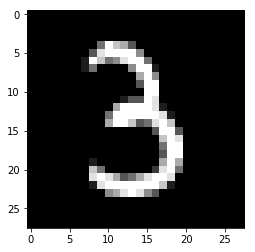

In [10]:
plt.imshow(image.squeeze(), cmap = 'gray')
print(label.item())

In [11]:
h_in = image.shape[2]
w_in = image.shape[3]
ops = 10

In [12]:
net = network(h_in, w_in, ops)

In [13]:
optimizer = optim.Adam(net.parameters(), lr = 0.01)

In [14]:
for params in net.state_dict():
    print(params, '\t', net.state_dict()[params].size())

conv0.weight 	 torch.Size([16, 1, 5, 5])
conv0.bias 	 torch.Size([16])
conv1.weight 	 torch.Size([32, 16, 5, 5])
conv1.bias 	 torch.Size([32])
lin0.weight 	 torch.Size([84, 512])
lin0.bias 	 torch.Size([84])
lin1.weight 	 torch.Size([10, 84])
lin1.bias 	 torch.Size([10])


In [15]:
for params in optimizer.state_dict():
    print(params, '\t', optimizer.state_dict()[params])

state 	 {}
param_groups 	 [{'lr': 0.01, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [140518608714128, 140518608714632, 140518608714920, 140518608712256, 140518608711968, 140518608715208, 140518608715280, 140518608714704]}]


In [16]:
def get_num_correct(out_pred, target_batch):
    return (out_pred == target_batch).sum().item()

In [17]:
# train the network on train_loader
def train_net():
    for epoch in range(20):
        net_loss = 0
        net_correct = 0
        for batch in train_loader:
            image_batch, target_batch = batch
            out_prob = net(image_batch)
            loss = f.nll_loss(out_prob, target_batch)
            net_loss += loss.item()
            net.zero_grad()
            loss.backward()
            optimizer.step()
            out_pred = out_prob.max(1, keepdim = True)[1].squeeze()
            net_correct += get_num_correct(out_pred, target_batch)
        accuracy = net_correct/(float(len(train_set)))
        print(f'Epoch: {epoch}, num_correct: {net_correct} loss: {net_loss}, accuracy: {accuracy}')

In [18]:
train_net()

Epoch: 0, num_correct: 53283 loss: 171.97031772509217, accuracy: 0.88805
Epoch: 1, num_correct: 56517 loss: 93.55323016643524, accuracy: 0.94195
Epoch: 2, num_correct: 56959 loss: 81.71773482486606, accuracy: 0.9493166666666667
Epoch: 3, num_correct: 56895 loss: 83.92582496628165, accuracy: 0.94825
Epoch: 4, num_correct: 57050 loss: 81.06128564476967, accuracy: 0.9508333333333333
Epoch: 5, num_correct: 57143 loss: 79.61949377134442, accuracy: 0.9523833333333334
Epoch: 6, num_correct: 57272 loss: 76.67358086630702, accuracy: 0.9545333333333333
Epoch: 7, num_correct: 57197 loss: 77.19203654676676, accuracy: 0.9532833333333334
Epoch: 8, num_correct: 57285 loss: 75.67764256894588, accuracy: 0.95475
Epoch: 9, num_correct: 57341 loss: 75.4374582041055, accuracy: 0.9556833333333333
Epoch: 10, num_correct: 57231 loss: 78.39679265581071, accuracy: 0.95385
Epoch: 11, num_correct: 57273 loss: 77.15493361279368, accuracy: 0.95455
Epoch: 12, num_correct: 57413 loss: 72.98243326321244, accuracy: 0.9

In [19]:
def fgsm_attack(original_image, epsilon, inp_grad):
    perturbed_image = original_image + epsilon * inp_grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [20]:
def generate_adv_samples(epsilon):
    classified_correct = 0
    adversarial_ex = []
    
    for image, label in test_loader:
        image.requires_grad = True
        out_prob = net(image)
        out_pred = out_prob.max(1, keepdim = True)[1]
        
        # if the model misclassifies an image then we just move on to next sample
        if out_pred != label:
            continue
        
        # find the loss the unperturbed image obtains by a backward pass through the network
        loss = f.nll_loss(out_prob, label)
        net.zero_grad()
        loss.backward()
        inp_grad = image.grad.data
        
        # attack the correctly classified image sample
        perturbed_image = fgsm_attack(image, epsilon, inp_grad)
        
        # run a forward pass on the model again using the perturbed image
        prob_perturbed = net(perturbed_image)
        out_perturbed = prob_perturbed.max(1, keepdim = True)[1]
        
        # if the model misclassifies the perturbed image, then we have creatred an adversarial example
        if out_perturbed != out_pred:
            if len(adversarial_ex) < 5:
                perturbed_image = perturbed_image.squeeze().detach().numpy()
                adversarial_ex.append((out_pred, out_perturbed, perturbed_image))
        else:
            classified_correct += 1
            if (epsilon == 0.00) and (len(adversarial_ex) < 5):
                perturbed_image = perturbed_image.squeeze().detach().numpy()
                adversarial_ex.append((out_pred, out_perturbed, perturbed_image))
                
    accuracy = classified_correct/float(len(test_loader))
    print(f'Epsilon = {epsilon}, number of correctly classified samples = {classified_correct} out of {len(test_loader)} samples, accuracy = {accuracy}')
    return adversarial_ex, accuracy

In [21]:
accuracies = []
adversarial_ex = []
for epsilon in epsilons:
    adv_ex, acc = generate_adv_samples(epsilon)
    accuracies.append(acc)
    adversarial_ex.append(adv_ex)

Epsilon = 0.0, number of correctly classified samples = 9255 out of 10000 samples, accuracy = 0.9255
Epsilon = 0.01, number of correctly classified samples = 9097 out of 10000 samples, accuracy = 0.9097
Epsilon = 0.05, number of correctly classified samples = 7620 out of 10000 samples, accuracy = 0.762
Epsilon = 0.1, number of correctly classified samples = 5881 out of 10000 samples, accuracy = 0.5881
Epsilon = 0.15, number of correctly classified samples = 5067 out of 10000 samples, accuracy = 0.5067
Epsilon = 0.2, number of correctly classified samples = 4566 out of 10000 samples, accuracy = 0.4566
Epsilon = 0.25, number of correctly classified samples = 4276 out of 10000 samples, accuracy = 0.4276
Epsilon = 0.3, number of correctly classified samples = 4046 out of 10000 samples, accuracy = 0.4046


In [22]:
def plot_acc():
    plt.figure(figsize = (8, 10))
    plt.xlabel('EPSILON')
    plt.ylabel('ACCURACY')
    plt.plot(accuracies)
    plt.grid()
    plt.show()

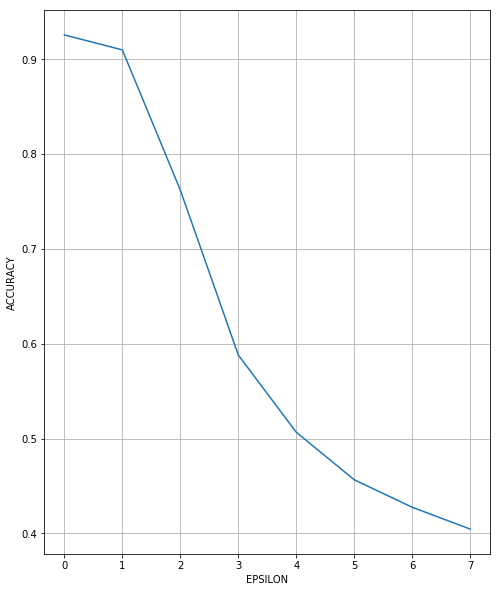

In [23]:
plot_acc()

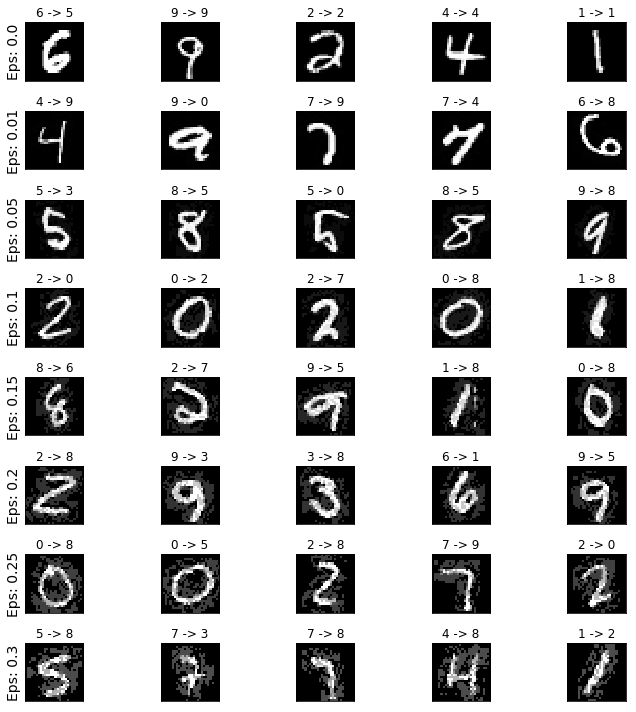

In [24]:
cnt = 0
plt.figure(figsize = (10, 10))
for i in range(len(epsilons)):
    for j in range(len(adversarial_ex[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(adversarial_ex[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig, adv, image = adversarial_ex[i][j]
        plt.title(f'{orig.item()} -> {adv.item()}')
        plt.imshow(image, cmap = 'gray')
plt.tight_layout()
plt.show()